En este documento se exploran los métodos clásicos de selección automática de variables. 

# Preliminares

En este documento se presentan varias alternativas para las selección automática de variables en modelos de regresión. Esta técnicas automáticas resulta útiles cuando nos enfrentamos a gran cantidad de variables y esto hace que el proceso manual sea difícil de abordar. En cualquier caso, hemos de saber que no son mágicas y que tienen sus debilidades, por lo que el control de las mismas por nuestra parte se hace fundamental de cara a la obtención de buenos resultados en su aplicación. 

Antes de leer los datos vamos a intentar trabajar con el archivo de funciones que tenemos creado para no tener necesidad de definir cada función cuando queramos utilizarla. Para ello leemos el archiv.py y lo ejecutamos. Dos variante: import si el archivo está en la carpeta del documento o execfile si está en otro directorio. 


In [1]:
# Si las funciones están en esta misma carpeta podemos hacer
from NuestrasFunciones import *

# De lo contrario podemos hacer algo así como...
#execfile('C:\\Users\\Guille\\Documents\\MineriaDatos_2022_23_Online\\NuestrasFunciones.py')

# O bien esto
#exec(open(r'C:\Users\Guille\Documents\Material Minería de Datos 2023_2024\Materíal Minería de Datos 2023_24_Gr3\NuestrasFunciones.py').read())


Procedemos a la lectura de los datos depurados y con las transformaciones creadas en el código de regresión lineal. 



In [9]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
pd.set_option("display.max_columns", None)

# Leer datos depurados datosvinoDep
todo_cont = pd.read_csv(r'C:\Users\Guille\Documents\Material Minería de Datos 2023_2024\Material Minería de Datos 2023_24_Feb Gr1\PARTE I_Depuracion y Regresiones\Dia2_Regresion Lineal\todo_cont_cor.csv', index_col=0)

# Descriptivo de comprobación
todo_cont.info()


<class 'pandas.core.frame.DataFrame'>
Index: 4998 entries, 0 to 4997
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Acidez               4998 non-null   float64
 1   AcidoCitrico         4998 non-null   float64
 2   Azucar               4998 non-null   float64
 3   CloruroSodico        4998 non-null   float64
 4   Densidad             4998 non-null   float64
 5   pH                   4998 non-null   float64
 6   Sulfatos             4998 non-null   float64
 7   Alcohol              4998 non-null   float64
 8   CalifProductor       4998 non-null   int64  
 9   PrecioBotella        4998 non-null   float64
 10  Etiqueta             4998 non-null   object 
 11  Clasificacion        4998 non-null   object 
 12  Region               4998 non-null   object 
 13  prop_missings        4998 non-null   float64
 14  aleatorio            4998 non-null   float64
 15  aleatorio2           4998 non-null   float6

In [10]:
# Vamos a eliminar los aleatorios para aligerar
todo_cont = todo_cont.loc[:,~todo_cont.columns.str.contains('aleat', case=False)]
todo_cont.head()

,Acidez,AcidoCitrico,Azucar,CloruroSodico,Densidad,pH,Sulfatos,Alcohol,CalifProductor,PrecioBotella,Etiqueta,Clasificacion,Region,prop_missings,Acidez_sqr,AcidoCitrico_exp,Azucar_sqr,CloruroSodico_sqr,Densidad_raiz4,pH_ident,Sulfatos_raiz4,Alcohol_sqrt,CalifProductor_sqrt,PrecioBotella_sqr,prop_missings_sqr,Beneficio
0,0.16,-0.81,26.10,-0.425,1.02792,3.38,0.70,10.3,2,1.00,M,***,Reg 1,7.142857,8.309692,5.573396,13.654046,2.516242,1.452933,3.340350,1.342872,1.701661,1.364559,1.000000e-08,3.670765e+00,515
1,2.64,-0.88,14.80,0.037,0.99518,3.12,0.48,22.0,3,3.38,M,***,Reg 3,0.000000,37.422272,5.132738,11.277112,9.349961,1.334062,2.949149,1.317718,2.486920,1.671222,2.613945e+00,1.000000e-08,585
2,-1.22,0.34,1.40,0.040,1.03236,3.20,-0.93,11.6,2,6.23,B,***,Reg 2,7.142857,1.172213,21.566661,8.752819,9.408488,1.466976,3.069518,1.106090,1.805854,1.364559,1.262167e+01,3.670765e+00,775
3,0.27,1.05,11.25,-0.007,0.99620,4.93,0.26,15.0,1,2.44,R,Desc,Reg 2,0.000000,9.157458,49.727992,10.577263,8.512550,1.338271,5.672506,1.291036,2.053514,0.964915,9.569796e-01,1.000000e-08,596
4,-0.22,0.39,1.80,-0.277,0.94724,3.09,0.75,12.6,3,4.31,R,****,Reg 2,0.000000,5.697821,22.873545,8.823546,4.233955,1.063663,2.904011,1.348396,1.882081,1.671222,5.055726e+00,1.000000e-08,1083


## Preparación de los datos
 
Como siempre, sacamos la variable objetivo para tenerla controlada y creamos el input. Como en esta ocasión vamos a trabajar más con el paradigma modelización mediante X,y, necesitaremos generar explítcitamente la matriz de diseño total con las categóricas extendidas en dummies y con constante. Vamos a hacerlo de forma manual. 
 


In [11]:
varObjCont = todo_cont.Beneficio
imput = todo_cont.drop(['Beneficio'],axis=1)

# Craer matriz de diseño 
imput_dummy = pd.get_dummies(imput, columns=['Clasificacion', 'Etiqueta', 'Region'], drop_first=False)

imput_dummy

,Acidez,AcidoCitrico,Azucar,CloruroSodico,Densidad,pH,Sulfatos,Alcohol,CalifProductor,PrecioBotella,prop_missings,Acidez_sqr,AcidoCitrico_exp,Azucar_sqr,CloruroSodico_sqr,Densidad_raiz4,pH_ident,Sulfatos_raiz4,Alcohol_sqrt,CalifProductor_sqrt,PrecioBotella_sqr,prop_missings_sqr,Clasificacion_*,Clasificacion_**,Clasificacion_***,Clasificacion_****,Clasificacion_Desc,Etiqueta_B,Etiqueta_M,Etiqueta_MB,Etiqueta_MM,Etiqueta_R,Region_Reg 1,Region_Reg 2,Region_Reg 3
0,0.16,-0.81,26.10,-0.425,1.02792,3.38,0.70,10.3,2,1.00,7.142857,8.309692,5.573396,13.654046,2.516242,1.452933,3.340350,1.342872,1.701661,1.364559,1.000000e-08,3.670765e+00,False,False,True,False,False,False,True,False,False,False,True,False,False
1,2.64,-0.88,14.80,0.037,0.99518,3.12,0.48,22.0,3,3.38,0.000000,37.422272,5.132738,11.277112,9.349961,1.334062,2.949149,1.317718,2.486920,1.671222,2.613945e+00,1.000000e-08,False,False,True,False,False,False,True,False,False,False,False,False,True
2,-1.22,0.34,1.40,0.040,1.03236,3.20,-0.93,11.6,2,6.23,7.142857,1.172213,21.566661,8.752819,9.408488,1.466976,3.069518,1.106090,1.805854,1.364559,1.262167e+01,3.670765e+00,False,False,True,False,False,True,False,False,False,False,False,True,False
3,0.27,1.05,11.25,-0.007,0.99620,4.93,0.26,15.0,1,2.44,0.000000,9.157458,49.727992,10.577263,8.512550,1.338271,5.672506,1.291036,2.053514,0.964915,9.569796e-01,1.000000e-08,False,False,False,False,True,False,False,False,False,True,False,True,False
4,-0.22,0.39,1.80,-0.277,0.94724,3.09,0.75,12.6,3,4.31,0.000000,5.697821,22.873545,8.823546,4.233955,1.063663,2.904011,1.348396,1.882081,1.671222,5.055726e+00,1.000000e-08,False,False,False,True,False,False,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,0.18,0.34,1.30,0.055,0.97759,2.04,0.07,7.8,3,6.03,0.000000,8.460769,21.566661,8.735182,9.703860,1.254265,1.324163,1.266582,1.480826,1.671222,1.167482e+01,1.000000e-08,False,True,False,False,False,False,True,False,False,False,False,True,False
4994,0.69,0.09,53.90,0.044,0.99480,3.55,0.42,8.1,2,4.19,14.285714,12.773082,16.070526,20.468480,9.486808,1.332484,3.596134,1.310602,1.509034,1.364559,4.695808e+00,1.468229e+01,False,False,True,False,False,False,False,True,False,False,False,False,True
4995,0.33,-0.94,-42.50,0.036,0.97287,2.99,2.14,14.0,4,1.81,7.142857,9.637229,4.782869,2.720183,9.330493,1.230027,2.753549,1.480354,1.983885,1.929752,3.028425e-01,3.670765e+00,False,True,False,False,False,False,False,False,False,True,True,False,False
4996,0.17,-1.10,37.00,0.078,0.99076,3.25,0.44,12.3,1,1.00,7.142857,8.385061,3.962111,16.162057,10.165631,1.315349,3.144749,1.312987,1.859541,0.964915,1.000000e-08,3.670765e+00,False,True,False,False,False,False,False,False,False,True,False,True,False


In [12]:

# Borramos los niveles que queramos como referencia (se incluirá su efecto implicito en las constante)
imput_dummy.drop(['Etiqueta_MM','Clasificacion_Desc','Region_Reg 1'], axis=1, inplace=True)

# Añadir constante
imput_dummy=sm.add_constant(imput_dummy)

imput_dummy.head()


,const,Acidez,AcidoCitrico,Azucar,CloruroSodico,Densidad,pH,Sulfatos,Alcohol,CalifProductor,PrecioBotella,prop_missings,Acidez_sqr,AcidoCitrico_exp,Azucar_sqr,CloruroSodico_sqr,Densidad_raiz4,pH_ident,Sulfatos_raiz4,Alcohol_sqrt,CalifProductor_sqrt,PrecioBotella_sqr,prop_missings_sqr,Clasificacion_*,Clasificacion_**,Clasificacion_***,Clasificacion_****,Etiqueta_B,Etiqueta_M,Etiqueta_MB,Etiqueta_R,Region_Reg 2,Region_Reg 3
0,1.0,0.16,-0.81,26.10,-0.425,1.02792,3.38,0.70,10.3,2,1.00,7.142857,8.309692,5.573396,13.654046,2.516242,1.452933,3.340350,1.342872,1.701661,1.364559,1.000000e-08,3.670765e+00,False,False,True,False,False,True,False,False,False,False
1,1.0,2.64,-0.88,14.80,0.037,0.99518,3.12,0.48,22.0,3,3.38,0.000000,37.422272,5.132738,11.277112,9.349961,1.334062,2.949149,1.317718,2.486920,1.671222,2.613945e+00,1.000000e-08,False,False,True,False,False,True,False,False,False,True
2,1.0,-1.22,0.34,1.40,0.040,1.03236,3.20,-0.93,11.6,2,6.23,7.142857,1.172213,21.566661,8.752819,9.408488,1.466976,3.069518,1.106090,1.805854,1.364559,1.262167e+01,3.670765e+00,False,False,True,False,True,False,False,False,True,False
3,1.0,0.27,1.05,11.25,-0.007,0.99620,4.93,0.26,15.0,1,2.44,0.000000,9.157458,49.727992,10.577263,8.512550,1.338271,5.672506,1.291036,2.053514,0.964915,9.569796e-01,1.000000e-08,False,False,False,False,False,False,False,True,True,False
4,1.0,-0.22,0.39,1.80,-0.277,0.94724,3.09,0.75,12.6,3,4.31,0.000000,5.697821,22.873545,8.823546,4.233955,1.063663,2.904011,1.348396,1.882081,1.671222,5.055726e+00,1.000000e-08,False,False,False,True,False,False,False,True,True,False


In [13]:
imput_dummy

,const,Acidez,AcidoCitrico,Azucar,CloruroSodico,Densidad,pH,Sulfatos,Alcohol,CalifProductor,PrecioBotella,prop_missings,Acidez_sqr,AcidoCitrico_exp,Azucar_sqr,CloruroSodico_sqr,Densidad_raiz4,pH_ident,Sulfatos_raiz4,Alcohol_sqrt,CalifProductor_sqrt,PrecioBotella_sqr,prop_missings_sqr,Clasificacion_**,Clasificacion_***,Clasificacion_****,Clasificacion_Desc,Etiqueta_B,Etiqueta_M,Etiqueta_MB,Etiqueta_R,Region_Reg 2,Region_Reg 3
0,1.0,0.16,-0.81,26.10,-0.425,1.02792,3.38,0.70,10.3,2,1.00,7.142857,8.309692,5.573396,13.654046,2.516242,1.452933,3.340350,1.342872,1.701661,1.364559,1.000000e-08,3.670765e+00,False,True,False,False,False,True,False,False,False,False
1,1.0,2.64,-0.88,14.80,0.037,0.99518,3.12,0.48,22.0,3,3.38,0.000000,37.422272,5.132738,11.277112,9.349961,1.334062,2.949149,1.317718,2.486920,1.671222,2.613945e+00,1.000000e-08,False,True,False,False,False,True,False,False,False,True
2,1.0,-1.22,0.34,1.40,0.040,1.03236,3.20,-0.93,11.6,2,6.23,7.142857,1.172213,21.566661,8.752819,9.408488,1.466976,3.069518,1.106090,1.805854,1.364559,1.262167e+01,3.670765e+00,False,True,False,False,True,False,False,False,True,False
3,1.0,0.27,1.05,11.25,-0.007,0.99620,4.93,0.26,15.0,1,2.44,0.000000,9.157458,49.727992,10.577263,8.512550,1.338271,5.672506,1.291036,2.053514,0.964915,9.569796e-01,1.000000e-08,False,False,False,True,False,False,False,True,True,False
4,1.0,-0.22,0.39,1.80,-0.277,0.94724,3.09,0.75,12.6,3,4.31,0.000000,5.697821,22.873545,8.823546,4.233955,1.063663,2.904011,1.348396,1.882081,1.671222,5.055726e+00,1.000000e-08,False,False,True,False,False,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,1.0,0.18,0.34,1.30,0.055,0.97759,2.04,0.07,7.8,3,6.03,0.000000,8.460769,21.566661,8.735182,9.703860,1.254265,1.324163,1.266582,1.480826,1.671222,1.167482e+01,1.000000e-08,True,False,False,False,False,True,False,False,True,False
4994,1.0,0.69,0.09,53.90,0.044,0.99480,3.55,0.42,8.1,2,4.19,14.285714,12.773082,16.070526,20.468480,9.486808,1.332484,3.596134,1.310602,1.509034,1.364559,4.695808e+00,1.468229e+01,False,True,False,False,False,False,True,False,False,True
4995,1.0,0.33,-0.94,-42.50,0.036,0.97287,2.99,2.14,14.0,4,1.81,7.142857,9.637229,4.782869,2.720183,9.330493,1.230027,2.753549,1.480354,1.983885,1.929752,3.028425e-01,3.670765e+00,True,False,False,False,False,False,False,True,False,False
4996,1.0,0.17,-1.10,37.00,0.078,0.99076,3.25,0.44,12.3,1,1.00,7.142857,8.385061,3.962111,16.162057,10.165631,1.315349,3.144749,1.312987,1.859541,0.964915,1.000000e-08,3.670765e+00,True,False,False,False,False,False,False,True,True,False


Hemos generado de otra forma la **matriz de diseño explícita** del problema de regresión. 

## Modelo manual ganador

Rescatamos el modelo ganador en nuestro proceso de ajuste manual de modelos de regresión lineal.


In [14]:
# Importamos la api para fórmulas (en concreto ols para regresión)
from statsmodels.formula.api import ols 

# Ajusto regresión de ejemplo
results = ols('Beneficio ~ Etiqueta + Clasificacion + CalifProductor',data=todo_cont).fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Beneficio   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.429
Method:                 Least Squares   F-statistic:                     417.5
Date:                Sat, 11 May 2024   Prob (F-statistic):               0.00
Time:                        10:50:45   Log-Likelihood:                -32718.
No. Observations:                4998   AIC:                         6.546e+04
Df Residuals:                    4988   BIC:                         6.552e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               685.0361      9.160     74.785      0.000     667.078     702.994
Etiqueta[T.M]          -260.8310      7.274    -35.860      0.000    -275.090    -246.572
Etiqueta[T.MB]          110.0158     13.621      8.077      0.000      83.313     136.719
Etiqueta[T.MM]         -383.5965     13.165    -29.139      0.000    -409.405    -357.788
Etiqueta[T.R]          -128.8278      6.274    -20.533      0.000    -141.128    -116.528
Clasificacion[T.**]      46.5888      6.406      7.273      0.000      34.030      59.147
Clasificacion[T.***]    106.5852      7.343     14.515      0.000      92.189     120.981
Clasificacion[T.****]   190.4255     11.068     17.206      0.000     168.728     212.123
Clasificacion[T.Desc]   -22.3735      8.136     -2.750      0.006     -38.323      -6.424
CalifProductor           -8.8354      2.224     -3.972      0.000     -13.196      -4.475
==============================================================================
Omnibus:                      135.699   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              146.450
Skew:                           0.419   Prob(JB):                     1.58e-32
Kurtosis:                       3.048   Cond. No.                         20.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Selección secuencial de variables 

Vamos a probar ahora los métodos clásicos de selección de variables que, partiendo del modelo completo/nulo eliminarán/añadirán secuencialmente variables hasta un número indicado o bien hasta alcanzar el score mejor o de mayor parsimonia. 

En primer lugar, presentamos la función **SequentialFeatureSelector** del paquete **mlxtend** que realiza la adición/eliminación secuencial de variables de forma automática basando los resultados en una cierta métrica (puede ser R2) por validación cruzada para cada subconjunto probado en el proceso iterativo. Con ello, se obtienen una serie de valores de ajuste por conjunto de variables probado y se escoge una configuración de entre las probadas. Entre las posibilidades para el argumento *k_features*, tenemos: 

1. **'best'**: Escoge la configuración que maximiza la métrica escogida por CV. 
2. **'parsimonious'**: Escoge la configuración más simple que se encuentra a menos de una sd del óptimo. 
3. **n**: Escoge la mejor configuración de n variables 

Mas información sobre el paquete en la página del proyecto.

http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/

## Método backward-best

Aplicamos filosofía backward con configuración best y valoramos el gráfico de evolución de las métricas a lo largo del proceso. 


In [15]:
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

clf = LinearRegression()

# Definir el selector de variables
sfs_back = sfs(clf,k_features = 'best',
               forward=False,
               floating=False, 
               scoring='r2',
               cv=5,
               n_jobs=-1)

# Ajustar a los datos
sfs_back = sfs_back.fit(imput_dummy, varObjCont)

#print(sfs1.subsets_)

# Ver nombres de variables seleccionadas
print(sfs_back.k_feature_names_)

# Score po cv
sfs_back.k_score_


C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


('const', 'pH', 'prop_missings', 'Acidez_sqr', 'Azucar_sqr', 'pH_ident', 'Alcohol_sqrt', 'CalifProductor_sqrt', 'Clasificacion_*', 'Clasificacion_**', 'Clasificacion_***', 'Clasificacion_****', 'Etiqueta_B', 'Etiqueta_M', 'Etiqueta_MB', 'Etiqueta_R', 'Region_Reg 2')


0.4322079035238001

In [16]:
# Información completa del proceso
pd.DataFrame.from_dict(sfs_back.get_metric_dict()).T


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
33,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.4468097636794458, 0.41649811808256276, 0.41...",0.428132,"(const, Acidez, AcidoCitrico, Azucar, CloruroS...",0.016754,0.013035,0.006517
32,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14,...","[0.4467310391706897, 0.4200366159705765, 0.413...",0.428908,"(const, Acidez, AcidoCitrico, Azucar, CloruroS...",0.015851,0.012333,0.006166
31,"(0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 14, 15...","[0.4472208244976976, 0.4205137849364886, 0.413...",0.429338,"(const, Acidez, AcidoCitrico, Azucar, CloruroS...",0.015751,0.012255,0.006127
30,"(0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 12, 14, 15, 1...","[0.4483349933073979, 0.42045414410757687, 0.41...",0.429777,"(const, Acidez, AcidoCitrico, Azucar, Densidad...",0.015953,0.012412,0.006206
29,"(0, 1, 2, 5, 6, 7, 9, 10, 11, 12, 14, 15, 16, ...","[0.4484621084116608, 0.42079739878985833, 0.41...",0.430165,"(const, Acidez, AcidoCitrico, Densidad, pH, Su...",0.015882,0.012357,0.006178
28,"(0, 2, 5, 6, 7, 9, 10, 11, 12, 14, 15, 16, 17,...","[0.4484148751262136, 0.4212633978325473, 0.414...",0.430438,"(const, AcidoCitrico, Densidad, pH, Sulfatos, ...",0.015872,0.012349,0.006174
27,"(0, 2, 5, 6, 7, 9, 10, 11, 12, 14, 15, 16, 17,...","[0.4484453652407805, 0.4212766529182844, 0.415...",0.430703,"(const, AcidoCitrico, Densidad, pH, Sulfatos, ...",0.015704,0.012218,0.006109
26,"(0, 2, 5, 6, 7, 10, 11, 12, 14, 15, 16, 17, 18...","[0.4483912727761429, 0.42172773208150294, 0.41...",0.430935,"(const, AcidoCitrico, Densidad, pH, Sulfatos, ...",0.015707,0.01222,0.00611
25,"(0, 2, 5, 6, 7, 10, 11, 12, 14, 15, 16, 17, 18...","[0.4485303692175172, 0.422059173494436, 0.4153...",0.431154,"(const, AcidoCitrico, Densidad, pH, Sulfatos, ...",0.015676,0.012197,0.006098
24,"(0, 2, 5, 6, 7, 10, 11, 12, 14, 15, 17, 18, 19...","[0.44851285891443415, 0.42204284067209985, 0.4...",0.431297,"(const, AcidoCitrico, Densidad, pH, Sulfatos, ...",0.015632,0.012163,0.006081


### Visualicación del proceso de selección de variables

Una utilidad destacable es la obtención de un gráfico de evolución de los valores de ajuste por cv para todas las posibles configuraciones, que da una idea de la capacidad vs. complejidad de los modelos. De esta forma, podemos observar como a partir de una complejidad concreta en número de efectos, el modelo no tiene prácticamente ganancia en capacidad predictiva.


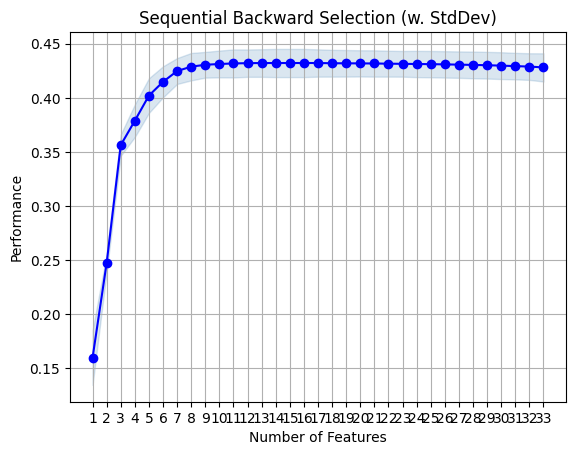

In [17]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

fig1 = plot_sfs(sfs_back.get_metric_dict(), kind='std_dev')

#plt.ylim([0.8, 1])
plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()


## Método forward-parsimonious

Probaremos un método forward con configuración más simple por parsimonia. 


In [18]:
# Sequential Forward Selection
sfs_forw = sfs(clf, 
          k_features='parsimonious', 
          forward=True, 
          floating=False, 
          scoring='r2',
          cv=5, n_jobs=-1)

sfs_forw = sfs_forw.fit(imput_dummy, varObjCont)

print('\nSequential Forward Selection:')
print(sfs_forw.k_feature_names_)
print('CV Score:')
print(sfs_forw.k_score_)



Sequential Forward Selection:
('Alcohol_sqrt', 'CalifProductor_sqrt', 'Clasificacion_**', 'Clasificacion_***', 'Clasificacion_****', 'Etiqueta_B', 'Etiqueta_M', 'Etiqueta_MB', 'Etiqueta_R')
CV Score:
0.43057510751795836


In [19]:
# Proceso backward
pd.DataFrame.from_dict(sfs_forw.get_metric_dict()).T


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(27,)","[0.16725115767617382, 0.18327860165590681, 0.1...",0.159645,"(Etiqueta_B,)",0.032475,0.025266,0.012633
2,"(27, 29)","[0.23524701105201928, 0.25589865536677636, 0.2...",0.247218,"(Etiqueta_B, Etiqueta_MB)",0.010441,0.008123,0.004062
3,"(27, 29, 30)","[0.3699222634754471, 0.3523319144660505, 0.340...",0.35626,"(Etiqueta_B, Etiqueta_MB, Etiqueta_R)",0.012648,0.00984,0.00492
4,"(26, 27, 29, 30)","[0.4075248017272155, 0.3688272326765005, 0.365...",0.378857,"(Clasificacion_****, Etiqueta_B, Etiqueta_MB, ...",0.019387,0.015083,0.007542
5,"(25, 26, 27, 29, 30)","[0.42058277553895107, 0.38738705692207587, 0.3...",0.402087,"(Clasificacion_***, Clasificacion_****, Etique...",0.020642,0.016061,0.00803
6,"(25, 26, 27, 28, 29, 30)","[0.4312504517888589, 0.40419500261306773, 0.39...",0.414812,"(Clasificacion_***, Clasificacion_****, Etique...",0.018434,0.014342,0.007171
7,"(24, 25, 26, 27, 28, 29, 30)","[0.4421887552798619, 0.4176247136363398, 0.408...",0.424791,"(Clasificacion_**, Clasificacion_***, Clasific...",0.015394,0.011977,0.005988
8,"(19, 24, 25, 26, 27, 28, 29, 30)","[0.4490631335008187, 0.42045889667690506, 0.41...",0.428819,"(Alcohol_sqrt, Clasificacion_**, Clasificacion...",0.016297,0.01268,0.00634
9,"(19, 20, 24, 25, 26, 27, 28, 29, 30)","[0.44807216698888286, 0.42095897648692515, 0.4...",0.430575,"(Alcohol_sqrt, CalifProductor_sqrt, Clasificac...",0.015286,0.011893,0.005947
10,"(12, 19, 20, 24, 25, 26, 27, 28, 29, 30)","[0.44975598354143054, 0.4220532417152655, 0.41...",0.431295,"(Acidez_sqr, Alcohol_sqrt, CalifProductor_sqrt...",0.015945,0.012406,0.006203


## Método backward-12 variables



In [20]:
# Sequential Forward Selection
sfs_12 = sfs(clf, 
          k_features= 12, 
          forward=False, 
          floating=True, 
          scoring='r2',
          cv=5)

sfs_12 = sfs_12.fit(imput_dummy, varObjCont)

print('\nSequential Forward Selection (k=12):')
print(sfs_12.k_feature_names_)
print('CV Score:')
print(sfs_12.k_score_)


C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is de

C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is de

C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is de

C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is de

C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is de

C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is de

C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is de

C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is de

C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is de

C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is de

C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is de

C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is de

C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is de

C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is de

C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is de

C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is de

C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is de

C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is de

C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is de


Sequential Forward Selection (k=12):
('Acidez_sqr', 'Alcohol_sqrt', 'CalifProductor_sqrt', 'Clasificacion_*', 'Clasificacion_**', 'Clasificacion_***', 'Clasificacion_****', 'Etiqueta_B', 'Etiqueta_M', 'Etiqueta_MB', 'Etiqueta_R', 'Region_Reg 2')
CV Score:
0.432077649292235


C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is de

## Método backward-10 variables



In [21]:
# Sequential Forward Selection
sfs_10 = sfs(clf, 
          k_features= 10, 
          forward=False, 
          floating=True, 
          scoring='r2',
          cv=5, n_jobs=-1)

sfs_10 = sfs_10.fit(imput_dummy, varObjCont)

print('\nSequential Backward Selection (k=10):')
print(sfs_10.k_feature_names_)
print('CV Score:')
print(sfs_10.k_score_)


C:\Users\Guille\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(



Sequential Backward Selection (k=10):
('Acidez_sqr', 'Alcohol_sqrt', 'CalifProductor_sqrt', 'Clasificacion_**', 'Clasificacion_***', 'Clasificacion_****', 'Etiqueta_B', 'Etiqueta_M', 'Etiqueta_MB', 'Etiqueta_R')
CV Score:
0.43129538016699714


## Comparación por validación cruzada

Comparamos el rendimiento de los modelos bajo el esquema de validación cruzada repetida creando una función similar a la que ya teníamos pero que, en esta ocasión trabaja sobre objetos de salida de los métodos de selección de variables de tal forma que en base a estos se seleccione el input adecuado y se ajuste el modelo lineal con las variables seleccionadas. 


In [27]:
# Creamos lista de fórmulas   
list_sfs = [sfs_back,sfs_forw,sfs_12,sfs_10]
list_sfs

# Aplicamos a toda la lista la función creada (devuelve un dataframe pero está transpuesto)
list_res = pd.DataFrame(map(lambda x: cross_val_selectVar(x,imput_dummy,varObjCont, seed=2022),list_sfs))

# Trasnponer dataframe y pasar de wide a long (creando un factor variable con el nombre de cada fórmula de la lista[0,1,2,3])
results = list_res.T.melt()
results.columns = ['Modelo','R2']
results.head()


Métrica r2: 0.430 (0.018)
Métrica r2: 0.430 (0.018)
Métrica r2: 0.431 (0.018)
Métrica r2: 0.430 (0.018)


,Modelo,R2
0,0,0.399866
1,0,0.457804
2,0,0.392098
3,0,0.427584
4,0,0.457710


In [28]:
results

,Modelo,R2
0,0,0.399866
1,0,0.457804
2,0,0.392098
3,0,0.427584
4,0,0.457710
...,...,...
395,3,0.413449
396,3,0.444973
397,3,0.438816
398,3,0.401028


<AxesSubplot: xlabel='Modelo', ylabel='R2'>

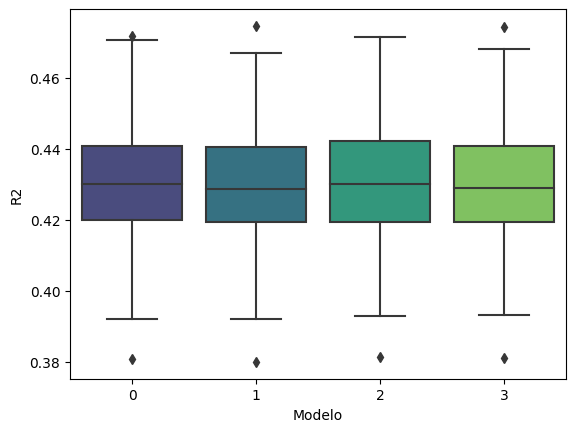

In [29]:
# Boxplot paralelo para comparar
sns.boxplot(x='Modelo',y='R2',data=results,palette='viridis')


## Creación de interacciones

Vamos ahora a considerar los efectos de interacción de orden 2 entre las variables para valorar si pueden aportar capacidad predictiva al modelo. 

Generaremos el dataset con las interacciones de todas las variables y posteriormente pasaremos los métodos de selección para hacer una criba de efectos interesantes. 


In [28]:
sel_col = ['const', 'CalifProductor', 
        'Acidez_sqr', 'Alcohol_sqrt', 'Clasificacion_**', 'Clasificacion_***', 'Clasificacion_****', 
        'Clasificacion_*', 'Etiqueta_B', 'Etiqueta_M', 'Etiqueta_MB', 
        'Etiqueta_R', 'Region_Reg 2']

imput_dummy_red = imput_dummy[sel_col].drop(['const'], axis=1)
imput_dummy_red.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4998 entries, 0 to 4997
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CalifProductor      4998 non-null   int64  
 1   Acidez_sqr          4998 non-null   float64
 2   Alcohol_sqrt        4998 non-null   float64
 3   Clasificacion_**    4998 non-null   bool   
 4   Clasificacion_***   4998 non-null   bool   
 5   Clasificacion_****  4998 non-null   bool   
 6   Clasificacion_*     4998 non-null   bool   
 7   Etiqueta_B          4998 non-null   bool   
 8   Etiqueta_M          4998 non-null   bool   
 9   Etiqueta_MB         4998 non-null   bool   
 10  Etiqueta_R          4998 non-null   bool   
 11  Region_Reg 2        4998 non-null   bool   
dtypes: bool(9), float64(2), int64(1)
memory usage: 200.1 KB


Para obtener interacciones de manera automática, sklearn proporciona la función **PolynomialFeatures**, que genera polinomios del grado indicado teniendo en cuenta las combinaciones de variables. Los efectos cuadráticos no nos interesan en ppio puesto que ya tenemos nuestas mejores transformaciones y nos quedaremos solamente con los efectos combinados de pares de variables. 



In [24]:
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures

# Create interaction terms (interaction of each regressor pair + polynomial)
#Interaction terms need to be created in both the test and train datasets
interaction = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
interaction

# Aplicar al dataset
X_inter = pd.DataFrame(interaction.fit_transform(imput_dummy_red), columns=interaction.get_feature_names_out(input_features=imput_dummy_red.columns))
X_inter.shape


(4998, 78)

In [25]:
X_inter

,CalifProductor,Acidez_sqr,Alcohol_sqrt,Clasificacion_**,Clasificacion_***,Clasificacion_****,Clasificacion_*,Etiqueta_B,Etiqueta_M,Etiqueta_MB,Etiqueta_R,Region_Reg 2,CalifProductor Acidez_sqr,CalifProductor Alcohol_sqrt,CalifProductor Clasificacion_**,CalifProductor Clasificacion_***,CalifProductor Clasificacion_****,CalifProductor Clasificacion_*,CalifProductor Etiqueta_B,CalifProductor Etiqueta_M,CalifProductor Etiqueta_MB,CalifProductor Etiqueta_R,CalifProductor Region_Reg 2,Acidez_sqr Alcohol_sqrt,Acidez_sqr Clasificacion_**,Acidez_sqr Clasificacion_***,Acidez_sqr Clasificacion_****,Acidez_sqr Clasificacion_*,Acidez_sqr Etiqueta_B,Acidez_sqr Etiqueta_M,Acidez_sqr Etiqueta_MB,Acidez_sqr Etiqueta_R,Acidez_sqr Region_Reg 2,Alcohol_sqrt Clasificacion_**,Alcohol_sqrt Clasificacion_***,Alcohol_sqrt Clasificacion_****,Alcohol_sqrt Clasificacion_*,Alcohol_sqrt Etiqueta_B,Alcohol_sqrt Etiqueta_M,Alcohol_sqrt Etiqueta_MB,Alcohol_sqrt Etiqueta_R,Alcohol_sqrt Region_Reg 2,Clasificacion_** Clasificacion_***,Clasificacion_** Clasificacion_****,Clasificacion_** Clasificacion_*,Clasificacion_** Etiqueta_B,Clasificacion_** Etiqueta_M,Clasificacion_** Etiqueta_MB,Clasificacion_** Etiqueta_R,Clasificacion_** Region_Reg 2,Clasificacion_*** Clasificacion_****,Clasificacion_*** Clasificacion_*,Clasificacion_*** Etiqueta_B,Clasificacion_*** Etiqueta_M,Clasificacion_*** Etiqueta_MB,Clasificacion_*** Etiqueta_R,Clasificacion_*** Region_Reg 2,Clasificacion_**** Clasificacion_*,Clasificacion_**** Etiqueta_B,Clasificacion_**** Etiqueta_M,Clasificacion_**** Etiqueta_MB,Clasificacion_**** Etiqueta_R,Clasificacion_**** Region_Reg 2,Clasificacion_* Etiqueta_B,Clasificacion_* Etiqueta_M,Clasificacion_* Etiqueta_MB,Clasificacion_* Etiqueta_R,Clasificacion_* Region_Reg 2,Etiqueta_B Etiqueta_M,Etiqueta_B Etiqueta_MB,Etiqueta_B Etiqueta_R,Etiqueta_B Region_Reg 2,Etiqueta_M Etiqueta_MB,Etiqueta_M Etiqueta_R,Etiqueta_M Region_Reg 2,Etiqueta_MB Etiqueta_R,Etiqueta_MB Region_Reg 2,Etiqueta_R Region_Reg 2
0,2.0,8.309692,1.701661,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,16.619385,3.403322,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,14.140280,0.000000,8.309692,0.000000,0.0,0.000000,8.309692,0.000000,0.000000,0.000000,0.000000,1.701661,0.000000,0.0,0.000000,1.701661,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.0,37.422272,2.486920,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,112.266817,7.460760,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,93.066195,0.000000,37.422272,0.000000,0.0,0.000000,37.422272,0.000000,0.000000,0.000000,0.000000,2.486920,0.000000,0.0,0.000000,2.486920,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,1.172213,1.805854,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.344427,3.611708,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,2.116846,0.000000,1.172213,0.000000,0.0,1.172213,0.000000,0.000000,0.000000,1.172213,0.000000,1.805854,0.000000,0.0,1.805854,0.000000,0.000000,0.000000,1.805854,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,9.157458,2.053514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,9.157458,2.053514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,18.804971,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,9.157458,9.157458,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,2.053514,2.053514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,3.0,5.697821,1.882081,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,17.093464,5.646244,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,3.0,10.723763,0.000000,0.000000,5.697821,0.0,0.000000,0.000000,0.000000,5.697821,5.697821,0.000000,0.000000,1.882081,0.0,0.000000,0.000000,0.000000,1.882081,1.882081,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

Algunas de esta interacciones se dan entre dummies para la misma variable, con lo cual no tienen sentido y el resultado será todo 0.. por ello, para aligerar proceso, eliminamos las columnas con varianza 0 del dataset. 



In [29]:
# Eliminar columnas constantes (interacciones sin sentido)
X_inter = X_inter.loc[:, X_inter.var() != 0.0]

X_inter.shape


(4998, 66)

Ahora ya tenemos el dataset con variables originales + transformaciones + interacciones interesantes de orden 2. 

## Selección secuencial con interacciones

Una vez tenemos el dataset con todas las interacciones relevantes, podemos aplicar sobre este la selección secuencial para valorar si hay efectos de interacción poderosos para el modelo. 

### Mejor configuración


In [27]:
# Sequential Forward Selection
sfs_forw_int_best = sfs(clf, 
          k_features='best', 
          forward=True, 
          floating=False, 
          scoring='r2',
          cv=4,n_jobs=-1)

sfs_forw_int_best = sfs_forw_int_best.fit(X_inter, varObjCont)

print('\nSequential Forward + Best Selection:')
print(sfs_forw_int_best.k_feature_names_)
print('CV Score:')
print(sfs_forw_int_best.k_score_)



Sequential Forward + Best Selection:
('Alcohol_sqrt', 'Clasificacion_**', 'Clasificacion_***', 'Clasificacion_****', 'Clasificacion_*', 'Etiqueta_B', 'Etiqueta_M', 'Etiqueta_MB', 'Etiqueta_R', 'CalifProductor Alcohol_sqrt', 'CalifProductor Clasificacion_****', 'Acidez_sqr Clasificacion_**', 'Acidez_sqr Etiqueta_M', 'Alcohol_sqrt Clasificacion_**', 'Alcohol_sqrt Etiqueta_B', 'Alcohol_sqrt Etiqueta_M', 'Alcohol_sqrt Etiqueta_R', 'Clasificacion_** Etiqueta_B', 'Clasificacion_*** Etiqueta_M', 'Clasificacion_*** Etiqueta_R', 'Clasificacion_**** Etiqueta_B', 'Clasificacion_**** Etiqueta_MB', 'Clasificacion_* Etiqueta_B', 'Etiqueta_B Region_Reg 2')
CV Score:
0.43371524067294875


Veamos el gráfico de proceso.



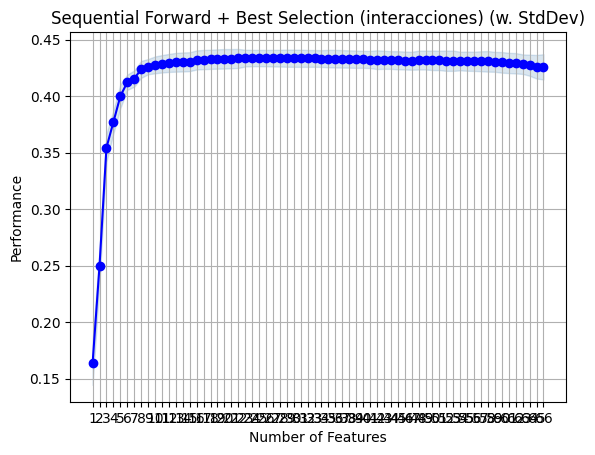

In [30]:
fig1 = plot_sfs(sfs_forw_int_best.get_metric_dict(), kind='std_dev')

#plt.ylim([0.8, 1])
plt.title('Sequential Forward + Best Selection (interacciones) (w. StdDev)')
plt.grid()
plt.show()


### Configuración con 10 variables



In [31]:
# Sequential Forward Selection
sfs_forw_int_10 = sfs(clf, 
          k_features=10, 
          forward=True, 
          floating=False, 
          scoring='r2',
          cv=4,n_jobs=-1)

sfs_forw_int_10 = sfs_forw_int_10.fit(X_inter, varObjCont)

print('\nSequential Forward 10 variables Selection:')
print(sfs_forw_int_10.k_feature_names_)
print('CV Score:')
print(sfs_forw_int_10.k_score_)



Sequential Forward 10 variables Selection:
('Alcohol_sqrt', 'Clasificacion_**', 'Clasificacion_***', 'Clasificacion_****', 'Etiqueta_M', 'Etiqueta_MB', 'CalifProductor Alcohol_sqrt', 'Alcohol_sqrt Etiqueta_B', 'Alcohol_sqrt Etiqueta_M', 'Alcohol_sqrt Etiqueta_R')
CV Score:
0.42768314606694446


# Selección de variables por LASSO

Exploramos la selección de variables por modelo laso con criterios AIC o BIC.

## Solo efectos principales

Aplicación de Lasso al dataset con variables originales + transformaciones. 


In [32]:
from sklearn import linear_model

reg = linear_model.LassoLarsIC(criterion='bic')

reg.fit(imput_dummy, varObjCont)

print(reg.coef_)


[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -8.68151928e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  3.82017720e+00 -7.69979905e+00  0.00000000e+00  8.08133105e-01
 -1.03180935e+00 -3.11965629e-02  0.00000000e+00 -2.66799738e-01
  0.00000000e+00  2.57193895e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -3.69345018e-01  0.00000000e+00  0.00000000e+00
  5.02445813e+01  1.08686780e+02  1.86795453e+02  3.21730106e+02
  5.77650314e+01  4.15806057e+02  1.92659213e+02  7.90835444e+00
  0.00000000e+00]


Para hacer la selección por Lasso y obtener la matriz de efecto seleccionados solamente, sencillamente eliminamos todos los coeficientes con parámetro estimado nulo haciendo una selección por columnas. 



In [33]:
selec_feats = imput_dummy[imput_dummy.columns[(reg.coef_ != 0).ravel().tolist()]]
selec_feats.columns


Index(['Azucar', 'Alcohol', 'CalifProductor', 'prop_missings', 'Acidez_sqr',
       'AcidoCitrico_exp', 'CloruroSodico_sqr', 'pH_ident',
       'PrecioBotella_sqr', 'Clasificacion_**', 'Clasificacion_***',
       'Clasificacion_****', 'Etiqueta_B', 'Etiqueta_M', 'Etiqueta_MB',
       'Etiqueta_R', 'Region_Reg 2'],
      dtype='object')

## Lasso con interacciones

Ahora aplicamos Lasso al archivo que contiene también las interacciones entre las variables de interés. 


In [40]:
X_inter

,CalifProductor,Acidez_sqr,Alcohol_sqrt,Clasificacion_**,Clasificacion_***,Clasificacion_****,Clasificacion_Desc,Etiqueta_B,Etiqueta_M,Etiqueta_MB,Etiqueta_R,Region_Reg 2,CalifProductor Acidez_sqr,CalifProductor Alcohol_sqrt,CalifProductor Clasificacion_**,CalifProductor Clasificacion_***,CalifProductor Clasificacion_****,CalifProductor Clasificacion_Desc,CalifProductor Etiqueta_B,CalifProductor Etiqueta_M,CalifProductor Etiqueta_MB,CalifProductor Etiqueta_R,CalifProductor Region_Reg 2,Acidez_sqr Alcohol_sqrt,Acidez_sqr Clasificacion_**,Acidez_sqr Clasificacion_***,Acidez_sqr Clasificacion_****,Acidez_sqr Clasificacion_Desc,Acidez_sqr Etiqueta_B,Acidez_sqr Etiqueta_M,Acidez_sqr Etiqueta_MB,Acidez_sqr Etiqueta_R,Acidez_sqr Region_Reg 2,Alcohol_sqrt Clasificacion_**,Alcohol_sqrt Clasificacion_***,Alcohol_sqrt Clasificacion_****,Alcohol_sqrt Clasificacion_Desc,Alcohol_sqrt Etiqueta_B,Alcohol_sqrt Etiqueta_M,Alcohol_sqrt Etiqueta_MB,Alcohol_sqrt Etiqueta_R,Alcohol_sqrt Region_Reg 2,Clasificacion_** Etiqueta_B,Clasificacion_** Etiqueta_M,Clasificacion_** Etiqueta_MB,Clasificacion_** Etiqueta_R,Clasificacion_** Region_Reg 2,Clasificacion_*** Etiqueta_B,Clasificacion_*** Etiqueta_M,Clasificacion_*** Etiqueta_MB,Clasificacion_*** Etiqueta_R,Clasificacion_*** Region_Reg 2,Clasificacion_**** Etiqueta_B,Clasificacion_**** Etiqueta_M,Clasificacion_**** Etiqueta_MB,Clasificacion_**** Etiqueta_R,Clasificacion_**** Region_Reg 2,Clasificacion_Desc Etiqueta_B,Clasificacion_Desc Etiqueta_M,Clasificacion_Desc Etiqueta_MB,Clasificacion_Desc Etiqueta_R,Clasificacion_Desc Region_Reg 2,Etiqueta_B Region_Reg 2,Etiqueta_M Region_Reg 2,Etiqueta_MB Region_Reg 2,Etiqueta_R Region_Reg 2
0,2.0,8.309692,1.701661,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,16.619385,3.403322,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,14.140280,0.000000,8.309692,0.000000,0.000000,0.000000,8.309692,0.000000,0.000000,0.000000,0.000000,1.701661,0.000000,0.000000,0.000000,1.701661,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.0,37.422272,2.486920,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,112.266817,7.460760,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,93.066195,0.000000,37.422272,0.000000,0.000000,0.000000,37.422272,0.000000,0.000000,0.000000,0.000000,2.486920,0.000000,0.000000,0.000000,2.486920,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,1.172213,1.805854,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.344427,3.611708,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,2.116846,0.000000,1.172213,0.000000,0.000000,1.172213,0.000000,0.000000,0.000000,1.172213,0.000000,1.805854,0.000000,0.000000,1.805854,0.000000,0.000000,0.000000,1.805854,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,9.157458,2.053514,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,9.157458,2.053514,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,18.804971,0.000000,0.000000,0.000000,9.157458,0.000000,0.000000,0.000000,9.157458,9.157458,0.000000,0.000000,0.000000,2.053514,0.000000,0.000000,0.000000,2.053514,2.053514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
4,3.0,5.697821,1.882081,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,17.093464,5.646244,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,3.0,10.723763,0.000000,0.000000,5.697821,0.000000,0.000000,0.000000,0.000000,5.697821,5.697821,0.000000,0.000000,1.882081,0.000000,0.000000,0.000000,0.000000,1.882081,1.882081,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,3.0,8.460769,1.480826,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,25.382308,4.442479,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,12.528931,8

In [34]:
lasso_int = linear_model.LassoLarsIC(criterion='bic')

lasso_int.fit(X_inter, varObjCont)

print(lasso_int.coef_)


[ -1.31756137 -11.29829108   0.           0.          53.84642167
   0.           0.          49.88008111   0.           0.
   0.           0.           0.25718903  -9.73517878   6.77333327
   9.36886741  31.82791884   0.           0.           0.
  40.98659215   0.69042233   1.04632331   0.           0.81509362
   2.26212465   6.53194165   2.40331769   8.31244628   6.96759528
  11.55520775   8.65340893   0.60914364  21.78702101  10.60841134
  31.13365331  -5.40536911 112.56498707   0.         117.59378316
  64.71159227   0.2176787    0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           7.9690326    0.           0.
   0.        ]


Obtenemos la sub selección de la misma forma.



In [35]:
selec_feats_int = X_inter[X_inter.columns[(lasso_int.coef_ != 0).ravel().tolist()]]
selec_feats_int.columns


Index(['CalifProductor', 'Acidez_sqr', 'Clasificacion_***', 'Etiqueta_B',
       'CalifProductor Acidez_sqr', 'CalifProductor Alcohol_sqrt',
       'CalifProductor Clasificacion_**', 'CalifProductor Clasificacion_***',
       'CalifProductor Clasificacion_****', 'CalifProductor Etiqueta_MB',
       'CalifProductor Etiqueta_R', 'CalifProductor Region_Reg 2',
       'Acidez_sqr Clasificacion_**', 'Acidez_sqr Clasificacion_***',
       'Acidez_sqr Clasificacion_****', 'Acidez_sqr Clasificacion_*',
       'Acidez_sqr Etiqueta_B', 'Acidez_sqr Etiqueta_M',
       'Acidez_sqr Etiqueta_MB', 'Acidez_sqr Etiqueta_R',
       'Acidez_sqr Region_Reg 2', 'Alcohol_sqrt Clasificacion_**',
       'Alcohol_sqrt Clasificacion_***', 'Alcohol_sqrt Clasificacion_****',
       'Alcohol_sqrt Clasificacion_*', 'Alcohol_sqrt Etiqueta_B',
       'Alcohol_sqrt Etiqueta_MB', 'Alcohol_sqrt Etiqueta_R',
       'Alcohol_sqrt Region_Reg 2', 'Etiqueta_B Region_Reg 2'],
      dtype='object')

## Validación Cruzada para interacciones

Vamos a aplicar la validación cruzada repetida para los modelos de selección atuomática sfs y Lasso para obtener los valores de sesgo-varianza de las estimaciones. Como siempre, creamos lista de modelos y aplicamos con map la función **cross_val_selectVar** a toda la lista, obteniendo un dataframe con Modelo y Valores de R2 en cv (100 valores por modelo). Luego agrupación y cuentas y boxplot.


In [36]:
list_sfs = [sfs_forw_int_best,sfs_forw_int_10,selec_feats,selec_feats_int]
list_sfs


# Aplicamos a toda la lista la función creada (devuelve un dataframe pero está transpuesto)
list_res = pd.DataFrame(map(lambda x: cross_val_selectVar(x,X_inter,varObjCont, seed=2022),list_sfs))

# Trasnponer dataframe y pasar de wide a long (creando un factor variable con el nombre de cada fórmula de la lista[0,1,2,3])
results_inter = list_res.T.melt()
results_inter.columns = ['Modelo','R2']
results_inter.head()


Métrica r2: 0.432 (0.019)
Métrica r2: 0.427 (0.018)
Métrica r2: 0.429 (0.019)
Métrica r2: 0.420 (0.019)


,Modelo,R2
0,0,0.404552
1,0,0.456885
2,0,0.396560
3,0,0.430063
4,0,0.460911


In [37]:
# Medias por Modelo (sesgo)
print(results_inter.groupby(['Modelo']).mean())

# Desviaciones por modelo (varianza)
results_inter.groupby(['Modelo']).std()


              R2
Modelo          
0       0.432150
1       0.427371
2       0.429306
3       0.419950


,R2
Modelo,
0,0.019077
1,0.017835
2,0.018676
3,0.018976


# Comparativa final 

Resumimos la comparativa de capacidad predictiva de: 

- Modelos sfs para variables originales + transformaciones
- Modelos sfs y Lasso para variables originales + transformaciones + interacciones


In [38]:
# Medias por Modelo (sesgo)
print(results.groupby(['Modelo']).mean())
results_inter.groupby(['Modelo']).mean()


              R2
Modelo          
0       0.430677
1       0.429736
2       0.430901
3       0.430313


,R2
Modelo,
0,0.432585
1,0.430040
2,0.428948
3,0.428544


Poca diferencia entre ellos. Con este panorama elegiríamos el modelo más simple. 

Recordemos el comportamiento por cv para el modelo manual. 


In [39]:
modeloManual_rev = cross_val_lin('Beneficio ~ Etiqueta + Clasificacion + CalifProductor + Acidez_sqr + Alcohol_sqrt  ', data=todo_cont, seed=2022)



Modelo: Beneficio ~ Etiqueta + Clasificacion + CalifProductor + Acidez_sqr + Alcohol_sqrt  
Coeficiente de determinación R2: 0.431 (0.018)


En este caso, para el archivo de vinos, las transformaciones e interacciones no aportan gran ganacia respecto a la consideración de modelo manual, por lo que no parece que merezca la pena introducir estos efectos que hacen el modelo más complejo para su interpretación. Conclusión, nuestro mejor modelo parece ser el manual en cuanto a parsimonia. 

En otras ocasiones, es muy posible que extendiendo nuestro set de variables con la consideración de interacciones y transformadas de variables aumente la capacidad predictiva de nuestros modelos. Ahí quedan un par de alternativas para la selección de variables de cara a la modelización predictiva. 

Cabe destacar que sklearn implementa otros métodos de selección de variables basados en modelos más modernos como Random Forest o Gradient Boosting. Consultar https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html para más información. 
